# Tracking spatial mismatch

This notebook demonstrates the issues when arise when the wrong spatial information is used when tracking and serializing the resulting data. Different mismatches in the affine matrix are purposefully introduced between the streamline generator, the tractogram instantiation and the file header to showcase different error situations.

We begin downloading the data.

In [36]:
import os
from pathlib import Path

from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, load_nifti_data

output_path = Path(os.getcwd())

# Get the Stanford data files through DIPY
t1_fname = get_fnames(name="stanford_t1")
dwi_fname, bval_fname, bvec_fname = get_fnames(name="stanford_hardi")
label_fname = get_fnames(name="stanford_labels")

# Load T1w data
t1_data = load_nifti_data(t1_fname)

# Load the tissue segmentation data
labels = load_nifti_data(label_fname)

# Load DWI data
dwi_data, _, dwi_img = load_nifti(dwi_fname, return_img=True)
bvals, bvecs = read_bvals_bvecs(bval_fname, bvec_fname)

Get the relevant volume properties.

In [37]:
from dipy.io.utils import get_reference_info

affine, dimensions, voxel_sizes, voxel_order = get_reference_info(dwi_img)

Build the gradient table.

In [38]:
from dipy.core.gradients import gradient_table

gtab = gradient_table(bvals, bvecs=bvecs)

Create the seeding mask.

In [39]:
seed_mask = labels == 2
white_matter = (labels == 1) | (labels == 2)

Build the objects for tracking: local orientation, stopping criterion and direction getter.

In [40]:
from dipy.data import small_sphere
from dipy.direction import ProbabilisticDirectionGetter
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel, auto_response_ssst
from dipy.reconst.shm import CsaOdfModel
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

# Fit the CSD model
sh_order_max = 6
response, ratio = auto_response_ssst(gtab, dwi_data, roi_radii=10, fa_thr=0.7)
csd_model = ConstrainedSphericalDeconvModel(gtab, response, sh_order_max=sh_order_max)
csd_fit = csd_model.fit(dwi_data, mask=white_matter)

# Build the image to serve as the stopping criterion for the tracking process
csa_model = CsaOdfModel(gtab, sh_order_max=sh_order_max)
gfa = csa_model.fit(dwi_data, mask=white_matter).gfa
sc = ThresholdStoppingCriterion(gfa, 0.25)

Define useful function for tracking and tractogram serialization purposes.

In [41]:
import nibabel as nib
from dipy.io.utils import  create_tractogram_header
from dipy.tracking import utils
from dipy.tracking.tracker import probabilistic_tracking
from nibabel.streamlines import detect_format
from nibabel.streamlines.tractogram import Tractogram

def remove_single_point_data(_streamlines):
    return [arr for arr in _streamlines if len(arr) > 1]

def create_streamlines(_seed_mask, _affine, _density, _csd_fit, _sphere, _sc, _max_angle, _step_size):
    _seeds = utils.seeds_from_mask(_seed_mask, _affine, density=_density)
    _fod = _csd_fit.odf(_sphere)
    _strml_gen = probabilistic_tracking(
        _seeds,
        _sc,
        _affine.astype(np.float64),
        sf=_fod,
        random_seed=1,
        sphere=_sphere,
        max_angle=_max_angle,
        step_size=_step_size,
    )
    return list(_strml_gen)

def create_header(_filename, _affine, _dimensions, _voxel_sizes, _voxel_order):
    _tractogram_type = detect_format(str(_filename))
    return _tractogram_type, create_tractogram_header(_tractogram_type, _affine, _dimensions, _voxel_sizes, _voxel_order)

def save_tracking(_streamlines, _affine, _tractogram_type, _header, _filename):
    _tractogram = Tractogram(_streamlines, affine_to_rasmm=_affine)
    fileobj = _tractogram_type(_tractogram, header=_header)
    nib.streamlines.save(fileobj, _filename)

Define tracking parameters and declare lists to store results.

In [42]:
density = 2
max_angle = 30.0
step_size = 0.5

streamlines = []
filenames = []

Now showcase different situations for the streamlines/tractogram data:
- __Case 1__: Matching affine for tracking and tractogram (in RASMM) + correct affine header
- __Case 2__: Mismatched affine between tracking and tractogram + correct affine header
- __Case 3__: Matching affine for tracking and tractogram (in VOX) + correct affine header
- __Case 4__: Matching affine for tracking but re-used for tractogram + correct affine header
- __Case 5__: Matching affine for tracking and tractogram (in RASMM) + incorrect affine header
- __Case 6__: Matching affine for tracking (in VOX) but not in tractogram + incorrect affine header


__Case 1__: Matching affine for tracking and tractogram (in RASMM) + correct affine header

Generates a file with streamlines correctly positioned in both VOX and RASMM space, and a file header that matches its associated NIFTI.

In [43]:
import numpy as np

_streamlines = create_streamlines(seed_mask, affine, density, csd_fit, small_sphere, sc, max_angle, step_size)

# Filter single point streamlines as they bear no meaning
_streamlines = remove_single_point_data(_streamlines)
streamlines.append(_streamlines)

filename = output_path / "tracking_match_rasmm_header_ok.trk"
filenames.append(str(filename))

tractogram_type, header = create_header(filename, affine, dimensions, voxel_sizes, voxel_order)
_affine = np.eye(4)
save_tracking(_streamlines, _affine, tractogram_type, header, filename)

__Case 2__: Mismatched affine between tracking and tractogram + correct affine header

Generates a file with streamlines correctly written in VOX space but not in RASMM space, and a file header that matches its associated NIFTI.

In [44]:
_affine = np.eye(4)
_streamlines = create_streamlines(seed_mask, _affine, density, csd_fit, small_sphere, sc, max_angle, step_size)
_streamlines = remove_single_point_data(_streamlines)
streamlines.append(_streamlines)

filename = output_path / "tracking_mismatch_header_ok.trk"
filenames.append(str(filename))

tractogram_type, header = create_header(filename, affine, dimensions, voxel_sizes, voxel_order)
# Provide the wrong affine
save_tracking(_streamlines, _affine, tractogram_type, header, filename)

__Case 3__: Matching affine for tracking and tractogram (in VOX) + correct affine header

Generates a file with streamlines correctly positioned in both VOX and RASMM space, and a file header that matches its associated NIFTI.

In [45]:
_affine = np.eye(4)
_streamlines = create_streamlines(seed_mask, _affine, density, csd_fit, small_sphere, sc, max_angle, step_size)
_streamlines = remove_single_point_data(_streamlines)
streamlines.append(_streamlines)

filename = output_path / "tracking_match_vox_header_ok.trk"
filenames.append(str(filename))

tractogram_type, header = create_header(filename, affine, dimensions, voxel_sizes, voxel_order)
# Provide the correct affine
save_tracking(_streamlines, affine, tractogram_type, header, filename)

__Case 4__: Matching affine for tracking but re-used for tractogram + correct affine header

Generates a file with streamlines correctly generated in RASMM space but moved again using RASMM affine before writing, and a file header that matches its associated NIFTI.

In [46]:
_streamlines = create_streamlines(seed_mask, affine, density, csd_fit, small_sphere, sc, max_angle, step_size)
_streamlines = remove_single_point_data(_streamlines)
streamlines.append(_streamlines)

filename = output_path / "tracking_mismatch_twice_header_ok.trk"
filenames.append(str(filename))

tractogram_type, header = create_header(filename, affine, dimensions, voxel_sizes, voxel_order)
# Provide the wrong affine
save_tracking(_streamlines, affine, tractogram_type, header, filename)

__Case 5__: Matching affine for tracking and tractogram (in RASMM) + incorrect affine header

Generates a file with streamlines correctly positioned in both VOX and RASMM space, but with a file header that does not match its associated NIFTI.

In [47]:
_streamlines = create_streamlines(seed_mask, affine, density, csd_fit, small_sphere, sc, max_angle, step_size)
_streamlines = remove_single_point_data(_streamlines)
streamlines.append(_streamlines)

filename = output_path / "tracking_match_header_notok.trk"
filenames.append(str(filename))

_affine = np.eye(4)
tractogram_type, header = create_header(filename, _affine, dimensions, voxel_sizes, voxel_order)
save_tracking(_streamlines, _affine, tractogram_type, header, filename)

__Case 6__: Matching affine for tracking (in VOX) but not in tractogram + incorrect affine header

Generate a file with streamlines correctly positioned in VOX space but not in RASMM space, and with a file header that does not match its associated NIFTI.

In [48]:
_affine = np.eye(4)
_streamlines = create_streamlines(seed_mask, _affine, density, csd_fit, small_sphere, sc, max_angle, step_size)
_streamlines = remove_single_point_data(_streamlines)
streamlines.append(_streamlines)

filename = output_path / "tracking_notok_header_notok.trk"
filenames.append(str(filename))

tractogram_type, header = create_header(filename, _affine, dimensions, voxel_sizes, voxel_order)
# Provide the wrong affine
save_tracking(_streamlines, _affine, tractogram_type, header, filename)

Define helper functions to plot the streamlines in 3D.

In [49]:
import matplotlib.pyplot as plt
from fury import actor, colormap, window

def compute_streamline_colors(_strml_data):
    local_orientation = [np.diff(list(s), axis=0) for s in _strml_data]
    ext_local_orientation = [[d[0]] + list(d) for d in local_orientation]
    orientations = np.asarray([o for d in ext_local_orientation for o in d])
    color = colormap.orient2rgb(orientations)
    return color

def plot_streamlines(_t1_data, _affine, _strml, _slice, _colors, _background, _size, _figsize, _title, _output_filename):
    scene = window.Scene()
    scene.background(_background)

    for _strml_data, _color in zip(_strml, _colors, strict=True):

        # Add slice actor
        slice_actor = actor.slicer(_t1_data, affine=_affine, value_range=(np.min(_t1_data), np.max(_t1_data)))
        x, y, z = _slice
        slice_actor.display(x=x, y=y, z=z)
        scene.add(slice_actor)

        # Add streamlines
        stream_actor = actor.line(_strml_data, colors=_color)
        scene.add(stream_actor)

    # Set the camera parameters to some appropriate values obtained interactively
    camera = scene.GetActiveCamera()
    position = (108.13570414379538, 296.6245671620285, 140.8498915184622)
    focal_point = (-54.04383850097656, -103.74394226074219, -13.222480773925781)
    view_up = (-0.17616761519637855, -0.2905670912406969, 0.9404976006582588)
    camera.SetPosition(position)
    camera.SetFocalPoint(focal_point)
    camera.SetViewUp(view_up)

    arr = window.snapshot(scene, fname=_output_filename, size=_size, offscreen=True)

    # Plot scene
    _fig, ax = plt.subplots(figsize=_figsize)
    ax.imshow(arr)
    ax.axis("off")
    ax.set_title(_title)

    plt.tight_layout()
    return _fig

Plot the streamlines.

/tmp/ipykernel_3912655/125640410.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


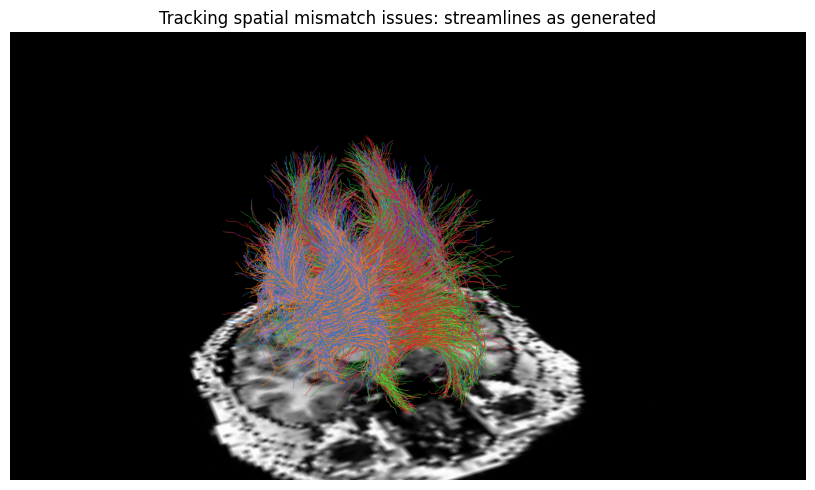

In [50]:
%matplotlib inline

# Plot an axial slice
_slice = (None, None, dimensions[2] // 4)

size = (1920, 1080)
figsize = (15, 5)
background = window.colors.black

colors = [compute_streamline_colors(streamlines[0])]
cmap = plt.get_cmap("tab10")
colors += [cmap(i) for i in range(5)]

output_filename = output_path / Path("tracking_spatial_mismatch-streamlines_generated.png")
title = "Tracking spatial mismatch issues: streamlines as generated"
fig = plot_streamlines(t1_data, affine, streamlines, _slice, colors, background, size, figsize, title, output_filename)
fig.show()


Note that the above visualization does not take into account the errors introduced when creating the tractograms and serializing them to disk.
So, now read the files from disk and plot streamlines.

/tmp/ipykernel_3912655/449612541.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


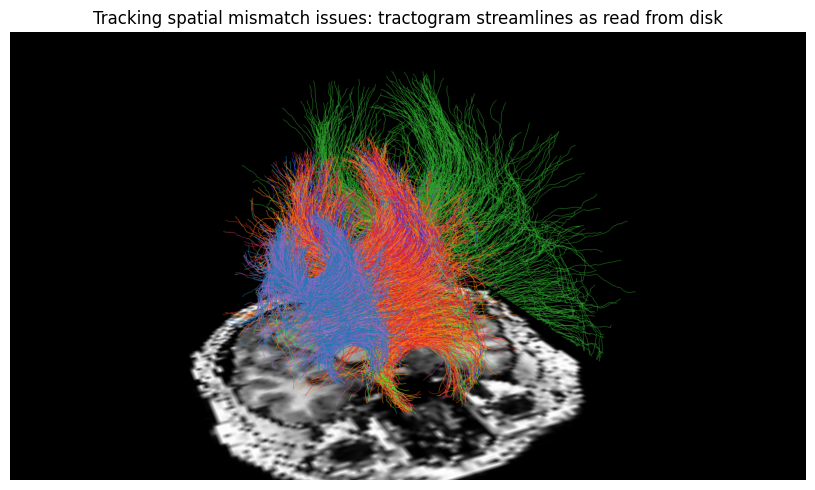

In [51]:
from dipy.io.streamline import load_tractogram

strml = []
for fname in filenames:
    _tractogram = load_tractogram(fname, "same", bbox_valid_check=False, trk_header_check=False)
    strml.append(_tractogram.streamlines)

title = "Tracking spatial mismatch issues: tractogram streamlines as read from disk"
output_filename = output_path / Path("tracking_spatial_mismatch-tractogram_streamlines_read.png")
fig = plot_streamlines(t1_data, affine, strml, _slice, colors, background, size, figsize, title, output_filename)
fig.show()